## Llama See, Llama Do: A Mechanistic Perspective on Contextual Entrainment and Distraction in LLMs

This notebook shows how to how to reproduce our main findings to our paper [Llama See, Llama Do: A Mechanistic Perspective on Contextual Entrainment and Distraction in LLMs](https://arxiv.org/abs/2505.09338). This notebook shows the first part -- the analysis on the phenomenon of contextual entrainment.

## Preparation

This is about importing stuff, loading models, etc

In [1]:

from textwrap import wrap
import string
import json
from pathlib import Path
from types import SimpleNamespace as Namespace

from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
torch.set_grad_enabled(False)
import nltk

import pandas as pd
from scipy.stats import ttest_rel
import seaborn as sns
import matplotlib.pyplot as plt

from head_search.head_analysis import HeadAnalysis
from head_search.data.lre_dataset import LREDataset

/scratch/251701/env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
mkdir -p failed for path /home/niu/.config/matplotlib: [Errno 13] Permission denied: '/home/niu'
Matplotlib created a temporary cache directory at /scratch/251701/matplotlib-88rfoisl because there was an issue with the default path (/home/niu/.config/matplotlib); it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
def process_logits(logits, tokenizer):
    probs = torch.softmax(logits[:, -1, :], dim=-1).squeeze()
    top_k_probs, top_k_indices = torch.topk(probs, 10)
    top_k_tokens = [tokenizer.decode([idx]) for idx in top_k_indices]

    lst = []
    for token, prob in zip(top_k_tokens, top_k_probs):
        lst.append((prob.item(), token))

    df = pd.DataFrame(lst, columns=['Token Probability', 'token'])
    return df

def plot_top_k_probs(model, tokenizer, context_prompts, prompt, k=10, add_label=False):
    if isinstance(context_prompts, str):
        context_prompts = [context_prompts]

    # No context is provided
    inputs = tokenizer(prompt, return_tensors='pt')
    input_ids = inputs['input_ids'].to(model.device)
    outputs = model(input_ids)
    df1 = process_logits(outputs.logits, tokenizer)

    wctx_dfs = []
    for context_prompt in context_prompts:
        # The distracting context is provided
        inputs = tokenizer(context_prompt + prompt, return_tensors='pt')
        input_ids = inputs['input_ids'].to(model.device)
        outputs = model(input_ids)
        df = process_logits(outputs.logits, tokenizer)
        wctx_dfs.append(df)

    fig, axes = plt.subplots(1, len(context_prompts)+1, figsize=((len(context_prompts)+1)*5, 2.6))
    sns.barplot(
        data=df1, 
        x='Token Probability', 
        y='token', 
        ax=axes[0], 
        orient='h'
    )
    title = '(a) '*add_label + '\n'.join(wrap(prompt, 50))
    axes[0].set_title(title)

    for i, (ax, df, context_prompt) in enumerate(zip(axes[1:], wctx_dfs, context_prompts)):
        sns.barplot(
            data=df, 
            x='Token Probability', 
            y='token', 
            ax=ax, 
            orient='h'
        )
        idx = string.ascii_lowercase[i+1]
        title = f'({idx}) '*add_label + '\n'.join(wrap(context_prompt + prompt, 45))
        ax.set_title(title)
    for ax in axes:
        ax.set(ylabel=None)


## Contextual Entrainment

In [32]:
model_name = "meta-llama/Llama-3.1-8B"

# load the tokenizer and the model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype="auto",
    device_map="auto"
)

Loading checkpoint shards: 100%|██████████| 4/4 [00:03<00:00,  1.28it/s]


This is the basic idea of contextual entrainment. LLMs can be distracted by various types of context. (a) When no context is provided to the model, it can confidently generate the correct response. (b) However, when context from a related topic is provided, the model may become distracted and produce incorrect responses. (c) The model continues to exhibit distractions across different formats and paraphrasing
of contextual information. (d) Just a single token, Asia, can distract the model. This indicates that the phenomenon of LLM distraction is more superficial and fundamental than previously suggested.

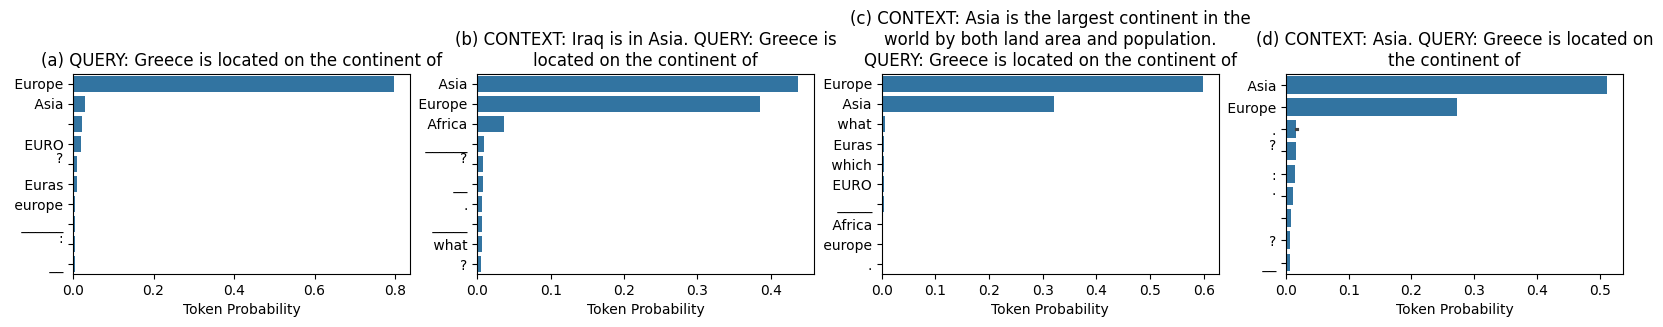

In [24]:
plot_top_k_probs(model, tokenizer,
    ['CONTEXT: Iraq is in Asia. ',
     'CONTEXT: Asia is the largest continent in the world by both land area and population. ',
     'CONTEXT: Asia. '],
     'QUERY: Greece is located on the continent of', add_label=True)

The result is also robust on other prompt templates.

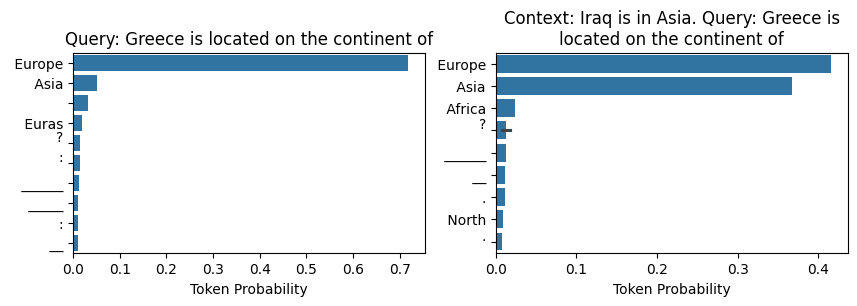

In [25]:
plot_top_k_probs(model, tokenizer, 'Context: Iraq is in Asia. ', 'Query: Greece is located on the continent of')

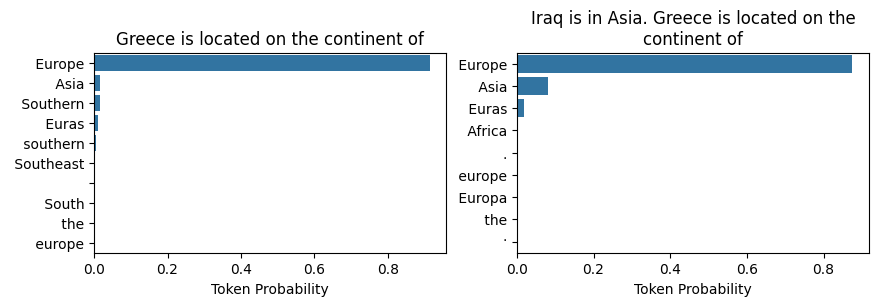

In [26]:
plot_top_k_probs(model, tokenizer, 'Iraq is in Asia. ', 'Greece is located on the continent of')

We also find that couterfactual context prompts can cause a bigger effect.

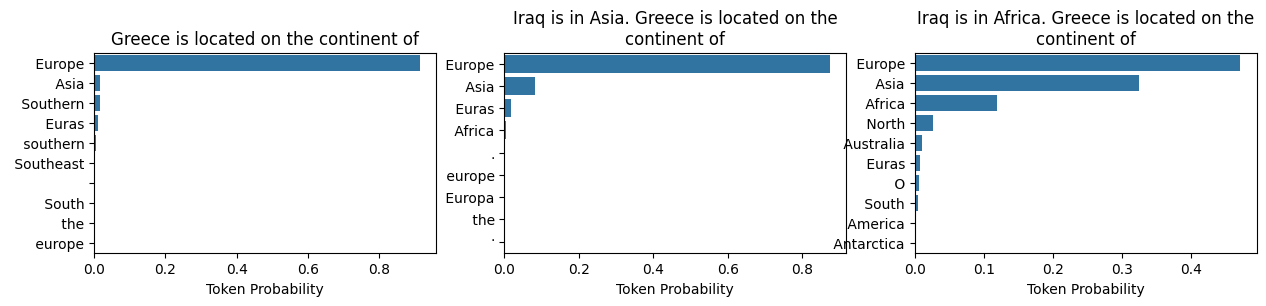

In [27]:
plot_top_k_probs(model, tokenizer,
    ['Iraq is in Asia. ', 'Iraq is in Africa. '],
    'Greece is located on the continent of')

This phenomenon is not limited to Llama. Other models, such as Qwen is also affected by this phenomenon.

In [28]:
del model, tokenizer

model_name = "Qwen/Qwen3-8B"

# load the tokenizer and the model
qwen_tokenizer = AutoTokenizer.from_pretrained(model_name)
qwen_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype="auto",
    device_map="auto"
)

Loading checkpoint shards: 100%|██████████| 5/5 [00:03<00:00,  1.58it/s]


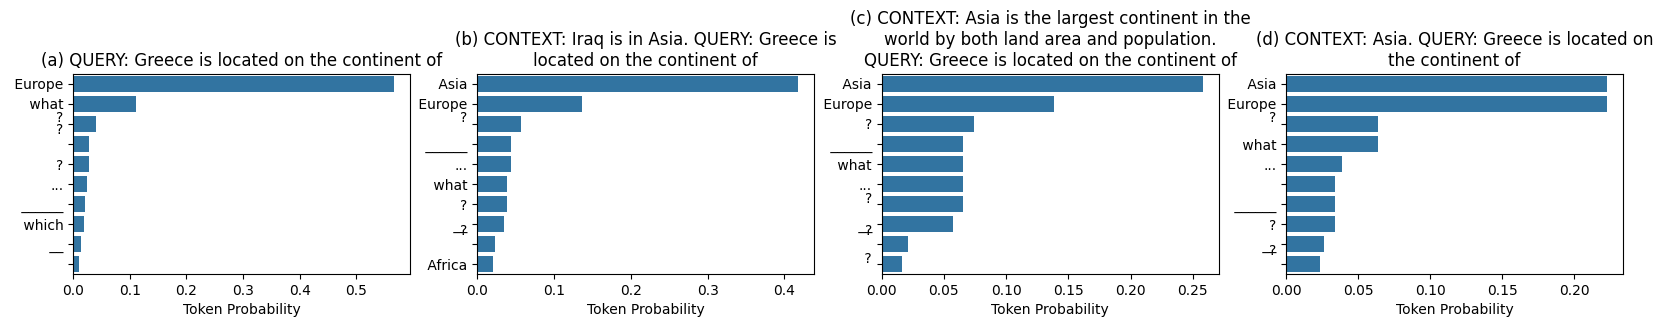

In [29]:
plot_top_k_probs(qwen_model, qwen_tokenizer,
    ['CONTEXT: Iraq is in Asia. ',
     'CONTEXT: Asia is the largest continent in the world by both land area and population. ',
     'CONTEXT: Asia. '],
     'QUERY: Greece is located on the continent of', add_label=True)

In [30]:
del qwen_tokenizer, qwen_model

model_name = "google/gemma-3-12b-it"

# load the tokenizer and the model
gemma_tokenizer = AutoTokenizer.from_pretrained(model_name)
gemma_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype="auto",
    device_map="auto"
)

Loading checkpoint shards: 100%|██████████| 5/5 [00:06<00:00,  1.30s/it]


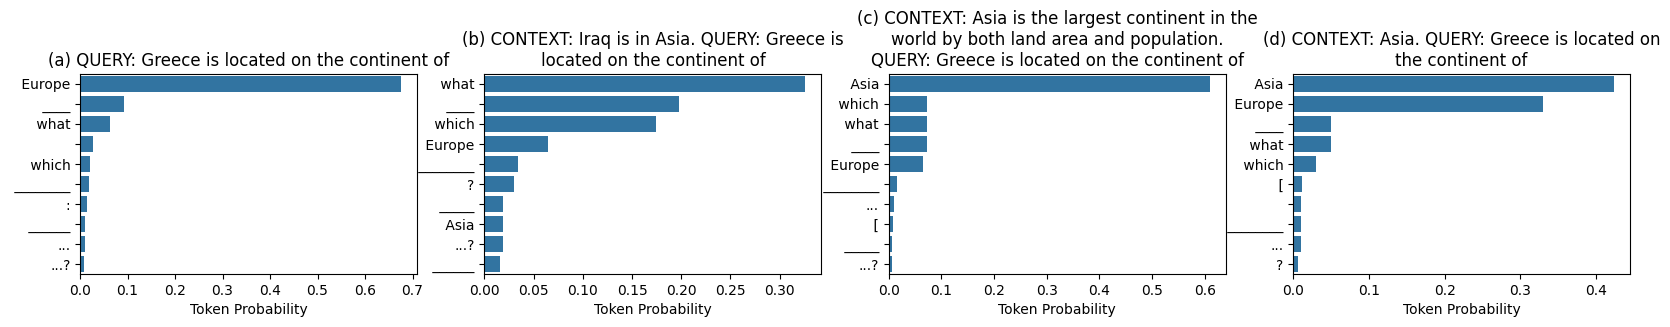

In [31]:
plot_top_k_probs(gemma_model, gemma_tokenizer,
    ['CONTEXT: Iraq is in Asia. ',
     'CONTEXT: Asia is the largest continent in the world by both land area and population. ',
     'CONTEXT: Asia. '],
     'QUERY: Greece is located on the continent of', add_label=True)

For the sake of simplicity, we will use Llama-3.1 going forward. You are welcome to reproduce our results on other models.

## Entrainment Heads

In [3]:
def plot_mask_model_logits(model, prompts, k=10):
    if isinstance(prompts, str):
        prompts = [prompts]

    dfs = []
    for prompt in prompts:
        outputs = model(prompt)
        df = process_logits(outputs, model.tokenizer)
        dfs.append(df)

    fig, axes = plt.subplots(1, len(prompts), figsize=(len(prompts)*5, 2.6))
    for i, (ax, df, prompt) in enumerate(zip(axes, dfs, prompts)):
        sns.barplot(
            data=df, 
            x='Token Probability', 
            y='token', 
            ax=ax, 
            orient='h'
        )
        
        title = '\n'.join(wrap(prompt, 45))
        ax.set_title(title)
        ax.set(ylabel=None)

In [ ]:
model = HeadAnalysis.from_pretrained('meta-llama/Llama-3.1-8B')

lre_path = Path('data/lre_dataset')

lre_data = LREDataset(lre_path, model.tokenizer)
model.setup_exp(lre_data.get_headsearch_data('country capital city'), 16)

mask_cfg = Namespace(
    use_attention_head_mask=True,
    use_deterministic_mask=False,
    run_with_mask=False,
    mask=None,
)
model.setup_mask_param(mask_cfg)

Loading the searched mask using the `country_capital_city` relation.

In [6]:
path = Path('head_search_results') / 'Llama-3.1-8B--country_capital_city--epoch406.json'
with open(path) as open_file:
    result = json.load(open_file)

mask = torch.tensor(result['dev']['mask'])

Without the mask (setting all the mask to 1 is equivalent to the original model), the model sees a large effect of contextual entrainment and distraction. Berlin receive a large increase in probability.

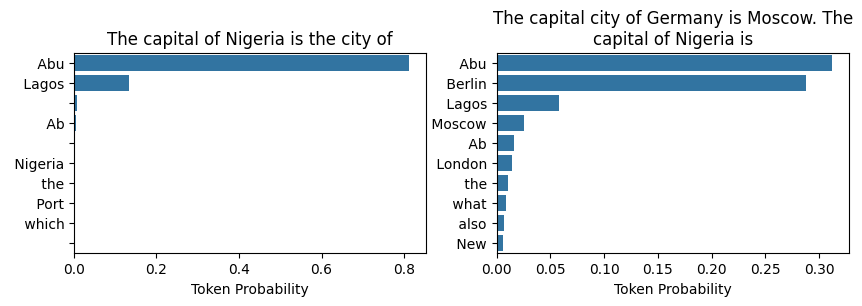

In [7]:
model.set_mask(torch.ones((32,32)).to(0))
plot_mask_model_logits(model, [
    'The capital of Nigeria is the city of',
    'The capital city of Germany is Moscow. The capital of Nigeria is',
])

When turning off the identified entrainment heads, contextual entrainment is drastically attenuated

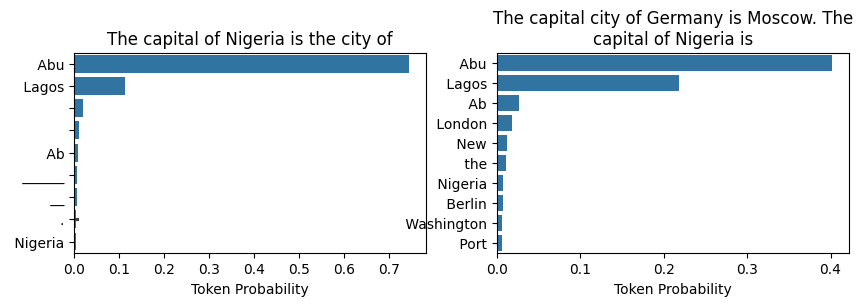

In [8]:
model.set_mask(mask.to(0))
plot_mask_model_logits(model, [
    'The capital of Nigeria is the city of',
    'The capital city of Germany is Moscow. The capital of Nigeria is',
])

This is a visualization of the identified heads

<Axes: >

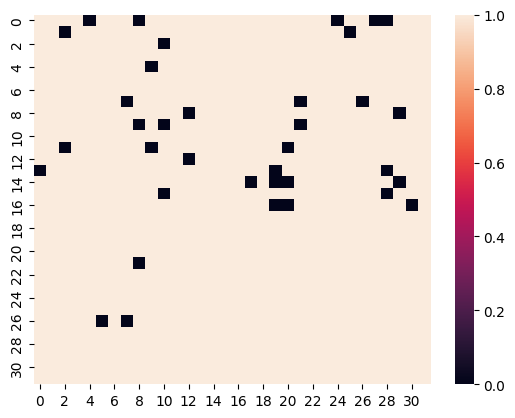

In [10]:
sns.heatmap(mask)